In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input,Lambda
from tensorflow.keras.callbacks import EarlyStopping,LambdaCallback
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
print("imported")

imported


In [2]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.
x_train = np.reshape(x_train,(60000,784))
x_test = np.reshape(x_test,(10000,784))

11501568/11490434 [==============================] - 0s 0us/step


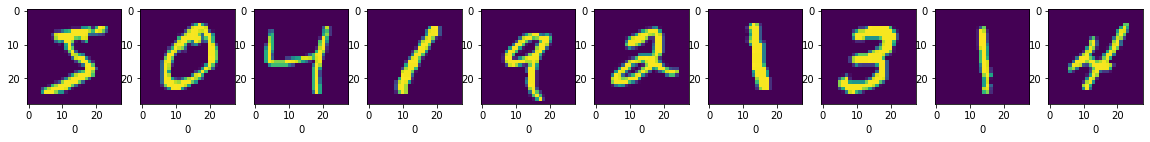

In [3]:
x_train_noisy = x_train + np.random.rand(60000,784)*0.9
x_test_noisy = x_test + np.random.rand(10000,784)*0.9
x_train_noisy = np.clip(x_train_noisy,0.,1.)
x_test_noisy = np.clip(x_test_noisy,0.,1.)
def plot(x,p,labels=True):
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].reshape(28,28))
        #plt.xticks([])
        #plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
plot(x_train,y_train)

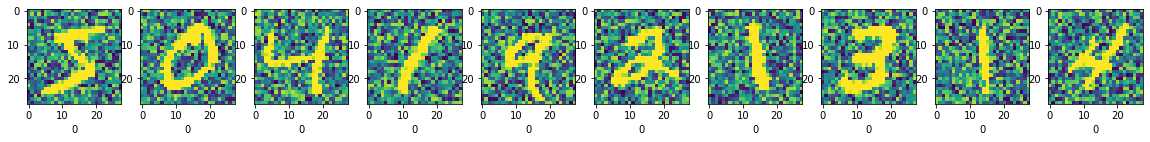

In [4]:
plot(x_train_noisy,y_train)

In [5]:
classifier = Sequential([Dense(512,activation='relu',input_shape=(784,)),
                         Dense(512,activation='relu'),
                         Dense(256,activation='relu'),
                         Dense(256,activation='relu'),
                         Dense(128,activation='relu'),
                         Dense(10,activation='softmax')])
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 895,882
Trainable params: 895,882
Non-trai

In [6]:
classifier.fit(x_train,y_train,batch_size=512,epochs=3)

Epoch 1/3
118/118 [==============================] - 7s 53ms/step - loss: 0.3493 - accuracy: 0.8979
Epoch 2/3
118/118 [==============================] - 6s 52ms/step - loss: 0.1062 - accuracy: 0.9685
Epoch 3/3
118/118 [==============================] - 6s 52ms/step - loss: 0.0684 - accuracy: 0.9786


In [7]:
loss,acc = classifier.evaluate(x_test,y_test)
print(loss)
print(acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.0867 - accuracy: 0.9737
0.0867435410618782
0.9736999869346619


In [8]:
loss,acc = classifier.evaluate(x_test_noisy,y_test)
print(loss)
print(acc)

313/313 [==============================] - 1s 4ms/step - loss: 5.7921 - accuracy: 0.2325
5.792136192321777
0.23250000178813934


In [14]:
def sampling(args):
    """Reparameterization trick. Instead of sampling from Q(z|X), 
    sample eps = N(0,I) z = z_mean + sqrt(var)*eps.

    Parameters:
    -----------
    args: list of Tensors
        Mean and log of variance of Q(z|X)

    Returns
    -------
    z: Tensor
        Sampled latent vector
    """

    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    print(eps)
    z = z_mean + tf.exp(z_log_var / 2) * eps
    print(z)
    return z

In [10]:
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128
latent_dim = 2  # The bigger this is, more accurate the network is but 2 is for illustration purposes.

In [12]:
#Encoder
num_features = 784
inputs = Input(shape=(num_features, ), name='input')
x = Dense(hidden_dim1, activation=tf.keras.layers.LeakyReLU(alpha=(0.01)))(inputs)
x = Dense(hidden_dim2, activation=tf.keras.layers.LeakyReLU(alpha=(0.01)))(x)
x = Dense(hidden_dim3, activation=tf.keras.layers.LeakyReLU(alpha=(0.01)))(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
print(z_mean.shape)
print(z_log_var.shape)
print(z_log_var)

(None, 2)
(None, 2)
KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='z_log_var/BiasAdd:0', description="created by layer 'z_log_var'")


In [15]:
#Sampling Layer
#Use reparameterization trick to push the sampling out as input

z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
print(z.shape) #as we are not training the z parameters must be 0 (bcz it's just a sampled value of z_mu and z_log_var)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 512)          401920      ['input[0][0]']                  
                                                                                                  
 dense_10 (Dense)               (None, 256)          131328      ['dense_9[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 128)          32896       ['dense_10[0][0]']               
                                                                                            

In [ ]:
#Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(hidden_dim3, activation=tf.keras.layers.LeakyReLU(alpha=(0.01)))(latent_inputs)
x = Dense(hidden_dim2, activation=tf.keras.layers.LeakyReLU(alpha=(0.01)))(x)
x = Dense(hidden_dim1, activation=tf.keras.layers.LeakyReLU(alpha=(0.01)))(x)
outputs = Dense(num_features, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 64)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 784)               402192    
Total params: 575,120
Trainable params: 575,120
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # VAE model = encoder + decoder
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
print(outputs.shape)
vae = Model(inputs, outputs, name='vae')

(None, 784)


In [ ]:
#VAE losses
# Reconstruction loss
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=['accuracy'])
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 64), (None,  582656      input[0][0]                      
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          575120      encoder[0][2]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          401920      input[0][0]                      
________________________________________________________________________________________________

In [ ]:
h = vae.fit(x_train_noisy,x_train,
                epochs=100,                  #take epochs as 100
                batch_size=512,
                #steps_per_epoch=118       #60000/512=118
                #validation_split=0.2,      #60000*0.2=12000
                verbose=1,                 #verbose maybe 0,1 or 2
                validation_data=(x_test_noisy,x_test),shuffle=True
                #callbacks=[EarlyStopping(monitor='val_loss',patience=3)]
                )

Epoch 1/100
118/118 [==============================] - 2s 9ms/step - loss: 64.8181 - accuracy: 0.0103 - val_loss: 64.1096 - val_accuracy: 0.0122
Epoch 2/100
118/118 [==============================] - 1s 7ms/step - loss: 64.1807 - accuracy: 0.0132 - val_loss: 64.0635 - val_accuracy: 0.0142
Epoch 3/100
118/118 [==============================] - 1s 7ms/step - loss: 64.1405 - accuracy: 0.0131 - val_loss: 63.9983 - val_accuracy: 0.0132
Epoch 4/100
118/118 [==============================] - 1s 7ms/step - loss: 64.1024 - accuracy: 0.0139 - val_loss: 63.9746 - val_accuracy: 0.0135
Epoch 5/100
118/118 [==============================] - 1s 7ms/step - loss: 64.0684 - accuracy: 0.0144 - val_loss: 63.9299 - val_accuracy: 0.0144
Epoch 6/100
118/118 [==============================] - 1s 7ms/step - loss: 63.9496 - accuracy: 0.0125 - val_loss: 63.6815 - val_accuracy: 0.0104
Epoch 7/100
118/118 [==============================] - 1s 7ms/step - loss: 63.6486 - accuracy: 0.0121 - val_loss: 63.4818 - val_ac

In [ ]:
loss,acc = vae.evaluate(x_test_noisy,x_test)
print(loss)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 60.8056 - accuracy: 0.0143
60.80563735961914
0.014299999922513962


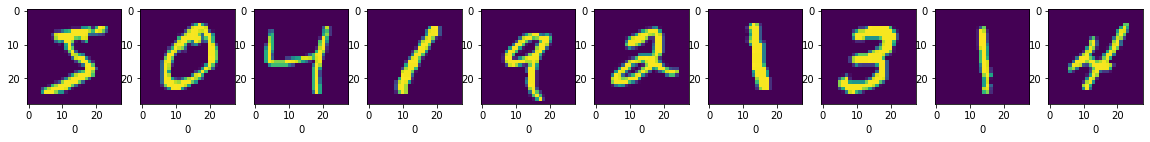

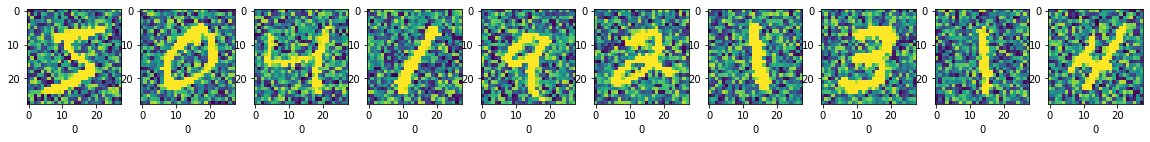

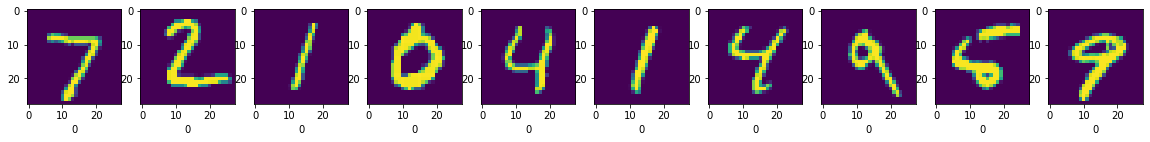

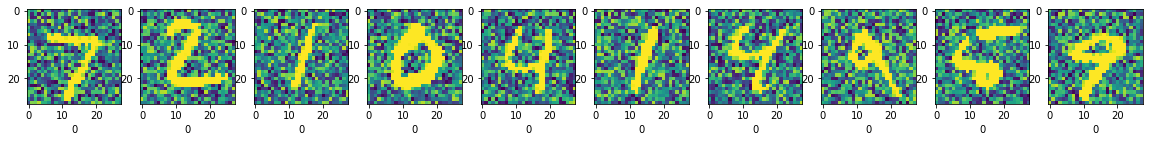

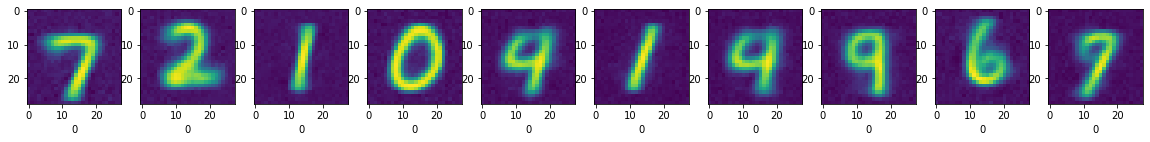

In [ ]:
prediction = vae.predict(x_test_noisy)
plot(x_train,y_train)
plot(x_train_noisy,y_train)
plot(x_test,y_test)
plot(x_test_noisy,y_test)
plot(prediction,y_test)

In [ ]:
loss,acc = classifier.evaluate(prediction,y_test)
print(loss)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 7.1461 - accuracy: 0.0850
7.146057605743408
0.08500000089406967


In [ ]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

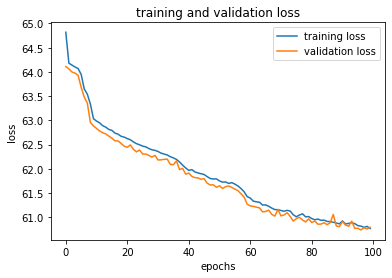

In [ ]:
plt.plot(h.history['loss'],label = 'training loss')
plt.plot(h.history['val_loss'],label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

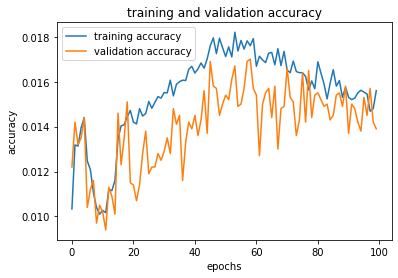

In [ ]:
plt.plot(h.history['accuracy'],label = 'training accuracy')
plt.plot(h.history['val_accuracy'],label = 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

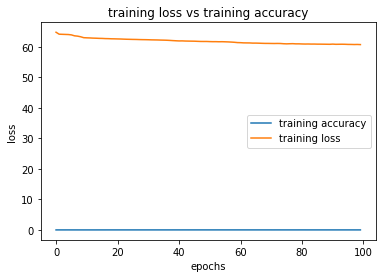

In [ ]:
plt.plot(h.history['accuracy'],label = 'training accuracy')
plt.plot(h.history['loss'],label = 'training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training loss vs training accuracy')
plt.legend()
plt.show()

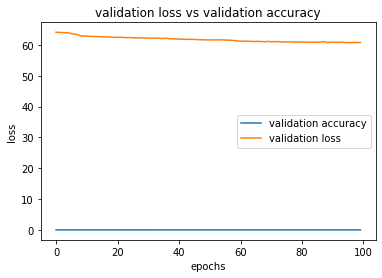

In [ ]:
plt.plot(h.history['val_accuracy'],label = 'validation accuracy')
plt.plot(h.history['val_loss'],label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('validation loss vs validation accuracy')
plt.legend()
plt.show()